# Project: Retinal vessel segmentation

The segmentation of retinal blood vessels from eye fundus images is of great significance for early diagnosis of eye-related diseases such as diabetes and hypertension.

The goal of this project is to read an eye fundus image like the following:
![](https://dlsi.ua.es/~pertusa/tvainput21.png)

And extract the blood vessels as can be seen in the corresponding ground-truth sample:

![](https://dlsi.ua.es/~pertusa/tvagt21.png)

All the images for this project are extracted from the [Drive](https://drive.grand-challenge.org) dataset.

For this task you can use any computer vision technique **except by deep neural networks, that are not allowed in this project**.

**Implementation**

To begin with the project, first download from moodle the folder with all the images and upload it to google drive.

Then, import the following libraries (you can add more):

In [21]:
import os
import cv2 as cv
import numpy as np 
from matplotlib import pyplot as plt

db_path = 'images/'

Now you should edit the following function to segment the image and return the obtained segmentation. This is only a simple (basic) skeleton that obviously is not performing well. Your project's goal is basically to complete this function. You can read the attached papers in Moodle to get ideas for the segmentation.

#### Enhancement

In [22]:
def create_linear_se(length, angle):
    """Create a linear structuring element at given angle"""
    angle_rad = np.deg2rad(angle)
    
    # Create line endpoints
    center = length // 2
    x = np.round(center + (length - 1) / 2 * np.cos(angle_rad)).astype(int)
    y = np.round(center + (length - 1) / 2 * np.sin(angle_rad)).astype(int)
    
    # Create SE
    se = np.zeros((length, length), dtype=np.uint8)
    cv.line(se, (center, center), (x, y), 1, 1)
    cv.line(se, (center, center), (2*center - x, 2*center - y), 1, 1)
    
    return se

def morphological_reconstruction(marker, mask):
    """
    Morphological reconstruction: grow marker under mask constraint
    Uses geodesic dilation
    """
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    
    while True:
        # Dilate marker
        dilated = cv.dilate(marker, kernel)
        
        # Keep result under mask
        reconstructed = cv.min(dilated, mask)
        
        # Check convergence
        if np.array_equal(reconstructed, marker):
            break
            
        marker = reconstructed
    
    return reconstructed

def mathematical_morph(img):
    '''  
    Smoothing operation used to enhance the blood vessels and suppress the background information.
    '''

    # Step 1: Apply opening operation at 12 angles
    opened_images = []
    for i in range(12):
        angle = i * 15
        se = create_linear_se(7, angle)
        opened = cv.morphologyEx(img, cv.MORPH_OPEN, se)
        opened_images.append(opened)
    
    # Take maximum response across all directions
    I_max = np.maximum.reduce(opened_images)
    
    # Morphological reconstruction: I_max is marker, image is mask
    I_s = morphological_reconstruction(I_max, img)


    # Step 2: Top-hat Transformation on 12 directions and then sum
    I_top = np.zeros_like(I_s, dtype=np.float64)
    for i in range(12):
        angle = i * 15  # 0°, 15°, 30°, ..., 165°
        se = create_linear_se(7, angle)
        tophat = cv.morphologyEx(I_s, cv.MORPH_BLACKHAT, se)
        
        # Accumulate
        I_top += tophat.astype(np.float64)
    
    # Standardize 
    I_top = 255 * (I_top - np.min(I_top)) / (np.max(I_top) - np.min(I_top))

    # Step 3: Gaussian Kernel Smoothing
    sigma = 0.7
    smoothed = cv.GaussianBlur(I_top.astype(np.float32), (3,3), sigmaX=sigma, sigmaY=sigma)

    return smoothed 

def bilateral_retinex(img, threshold=0.05):
    if img.dtype == np.uint8:
        img = (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img)) # Normalize to [0, 1] to prevent overflow
    else:
        img = img.astype(np.float32)

    mask = (img > threshold).astype(np.uint8)
    
    # Apply bilateral filter only to the masked region
    L = np.zeros_like(img)
    img_uint8 = (img * 255).astype(np.uint8)
    L_filtered = cv.bilateralFilter(img_uint8, d=15, sigmaColor=75, sigmaSpace=75)
    L_filtered = L_filtered.astype(np.float32) / 255.0
    L = np.where(mask, L_filtered, 0)

    # Compute reflectance R(x) in log domain
    # R(x) = log(I(x) + 1) - log(L(x) + 1)
    R = np.log(img + 1) - np.log(L + 1)

    # Apply mask to R to ensure background remains black
    R = R * mask

    # Normalize R to [0, 1] only for non-zero regions
    R_masked = R[mask > 0]
    R[mask > 0] = (R_masked - np.min(R_masked)) / (np.max(R_masked) - np.min(R_masked) + 1e-10)

    return R # return reflectance image normalized to [0, 1]

#### Segmentation

In [23]:
def segment(img, mask, thresh=25, inv=False):
    masked_img = img[mask > 0]
    threshold = np.percentile(masked_img, thresh) if inv == False else np.percentile(masked_img, 100 - thresh)
    binary = img <= threshold
    return np.logical_not(binary) * mask if inv == True else binary * mask

def remove_small_objects(img, min_size=100):
    # Find all connected components (white regions in binary image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img.astype(np.uint8), connectivity=8)
    
    # Create an output image to hold the filtered components
    output_img = np.zeros_like(img, dtype=np.uint8)
    
    # Iterate through all components and keep only those larger than min_size
    for label in range(1, num_labels):  # Skip the background label 0
        area = stats[label, cv.CC_STAT_AREA]
        if area >= min_size:
            output_img[labels == label] = 1  # Keep this component
    
    return output_img


#### Processing

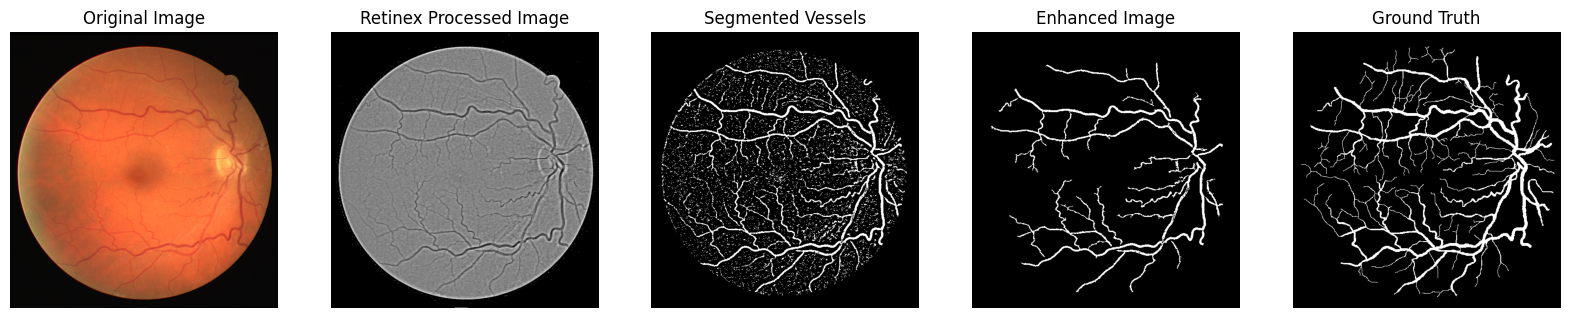

In [24]:
# NOTE: using retinex

sample_img = cv.imread('images/input/2.png', cv.IMREAD_COLOR_RGB)
mask_img = cv.imread('images/fov_mask.png', cv.IMREAD_GRAYSCALE)
erosion_kernel = np.ones((1,1), np.uint8) 
mask = cv.erode(mask_img, erosion_kernel, iterations=1)
gt = cv.imread('images/gt/2.png', cv.IMREAD_GRAYSCALE)
r,g,b = cv.split(sample_img)
gray_img = cv.cvtColor(sample_img, cv.COLOR_RGB2GRAY)

retinex_img = bilateral_retinex(g) # using green channel for better vessel contrast 
segmented_image = segment(retinex_img, mask, thresh=15)
enhanced_image = remove_small_objects(segmented_image)

plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.subplot(1,5,2)
plt.title('Retinex Processed Image')
plt.imshow(retinex_img, cmap='gray')
plt.axis('off')
plt.subplot(1,5,3)
plt.title('Segmented Vessels')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.subplot(1,5,4)
plt.title('Enhanced Image')
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')
plt.subplot(1,5,5)
plt.title('Ground Truth')
plt.imshow(gt, cmap='gray')
plt.axis('off')
#plt.savefig('report/assets/retinex.png')
plt.show()

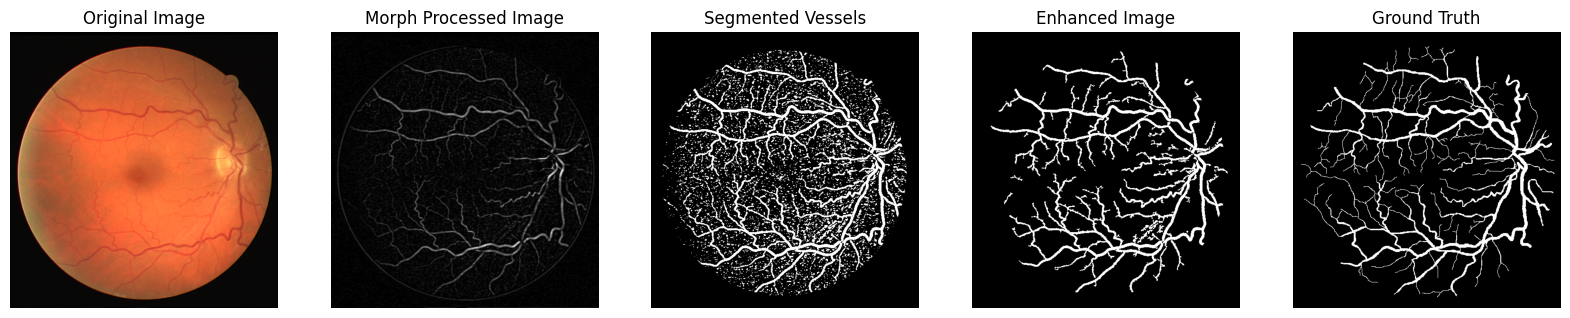

In [ ]:
# NOTE: using mathematical morph

sample_img = cv.imread('images/input/2.png', cv.IMREAD_COLOR_RGB)
mask_img = cv.imread('images/fov_mask.png', cv.IMREAD_GRAYSCALE)
erosion_kernel = np.ones((1,1), np.uint8) 
mask = cv.erode(mask_img, erosion_kernel, iterations=1)
gt = cv.imread('images/gt/2.png', cv.IMREAD_GRAYSCALE)
r,g,b = cv.split(sample_img)
gray_img = cv.cvtColor(sample_img, cv.COLOR_RGB2GRAY)

mat_morph = mathematical_morph(g)
segmented = segment(mat_morph, mask=mask, inv=True, thresh=25)
enhanced = remove_small_objects(segmented, min_size=75)

plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.subplot(1,5,2)
plt.title('Morph Processed Image')
plt.imshow(mat_morph, cmap='gray')
plt.axis('off')
plt.subplot(1,5,3)
plt.title('Segmented Vessels')
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.subplot(1,5,4)
plt.title('Enhanced Image')
plt.imshow(enhanced, cmap='gray')
plt.axis('off')
plt.subplot(1,5,5)
plt.title('Ground Truth')
plt.imshow(gt, cmap='gray')
plt.axis('off')
#plt.savefig('report/assets/morph.png')
plt.show()

#### Analysis

In [26]:
def vessel_segmentation_retinex(input_image):

    img = cv.imread(input_image, cv.IMREAD_COLOR_RGB)

    r,g,b = cv.split(img)
    retinex_img = bilateral_retinex(g)
    segmented_image = segment(retinex_img, cv.imread('images/fov_mask.png', cv.IMREAD_GRAYSCALE), thresh=25)
    enhanced_image = remove_small_objects(segmented_image, min_size=100)

    return enhanced_image

def vessel_segmentation_morph(input_image):

    img = cv.imread(input_image, cv.IMREAD_COLOR_RGB)

    r,g,b = cv.split(img)
    mat_morph = mathematical_morph(g)
    segmented = segment(mat_morph, mask=mask, inv=True, thresh=20)
    enhanced_image = remove_small_objects(segmented, min_size=100)

    return enhanced_image

Your project will be evaluated with the Intersection over Union (IoU) metric, commonly used in segmentation tasks. This is the function to read a ground truth image and return the IoU considering your segmented image.

In [27]:
def single_IoU(img_name):
    # Apply segmentation
    input_img = os.path.join(db_path, 'input', img_name)
    obtained_1 = vessel_segmentation_retinex(input_img)
    obtained_2 = vessel_segmentation_morph(input_img)

    # Path of the target (ground truth) image
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)

    # Show obtained results
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(obtained_1, cmap=plt.get_cmap('gray'))
    plt.title('Retinex')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(obtained_2, cmap=plt.get_cmap('gray'))
    plt.title('Morph')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(solution, cmap=plt.get_cmap('gray'))
    plt.title('Ground Truth Segmentation')
    plt.axis('off')
    plt.show()

    # IoU calculation
    intersectionAB_1 = cv.countNonZero(obtained_1 & solution)
    unionAB_1 = cv.countNonZero(obtained_1 | solution)
    score_1 = intersectionAB_1 / unionAB_1
    print("Image {} - IoU={}".format(img_name, score_1))

    intersectionAB_2 = cv.countNonZero(obtained_2 & solution)
    unionAB_2 = cv.countNonZero(obtained_2 | solution)
    score_2 = intersectionAB_2 / unionAB_2
    print("Image {} - IoU={}".format(img_name, score_2))

    return score_1, score_2

This is the evaluation method that reads all the images from the input folder and gets the mean IoU for all of them. This is the score of your project, the higher the better.

['8.png', '9.png', '14.png', '15.png', '17.png', '16.png', '12.png', '13.png', '11.png', '10.png', '20.png', '18.png', '19.png', '4.png', '5.png', '7.png', '6.png', '2.png', '3.png', '1.png']


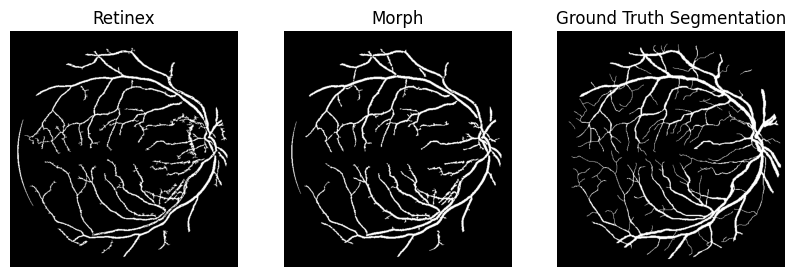

Image 8.png - IoU=0.531554168429962
Image 8.png - IoU=0.5837901950448076


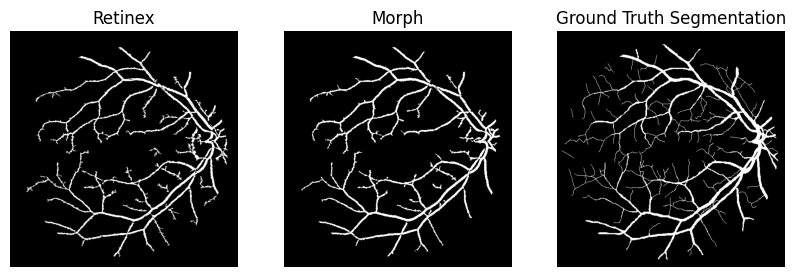

Image 9.png - IoU=0.548075174295241
Image 9.png - IoU=0.5796840692851916


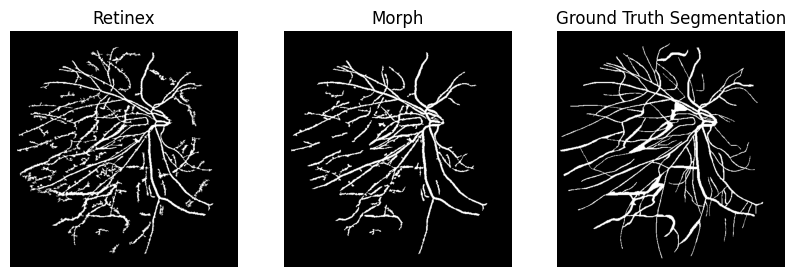

Image 14.png - IoU=0.4641408533683805
Image 14.png - IoU=0.4683553875236295


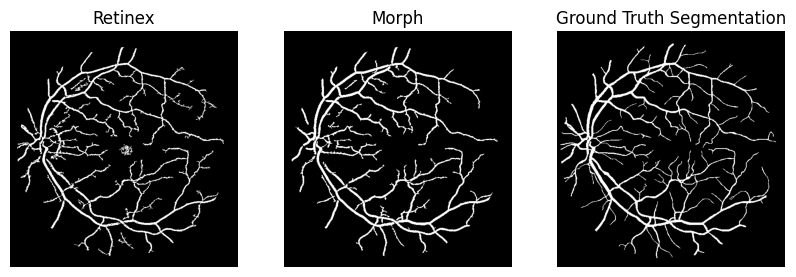

Image 15.png - IoU=0.595937527678545
Image 15.png - IoU=0.6268262987012987


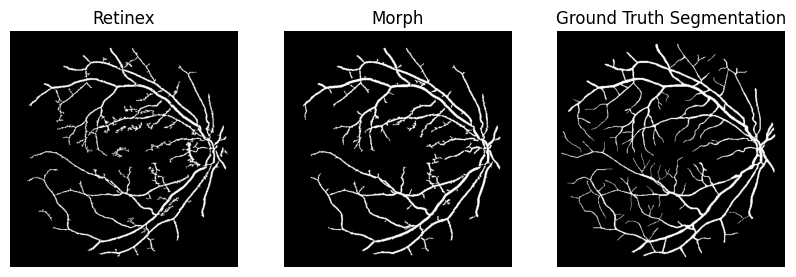

Image 17.png - IoU=0.5644350357237364
Image 17.png - IoU=0.6222509702457956


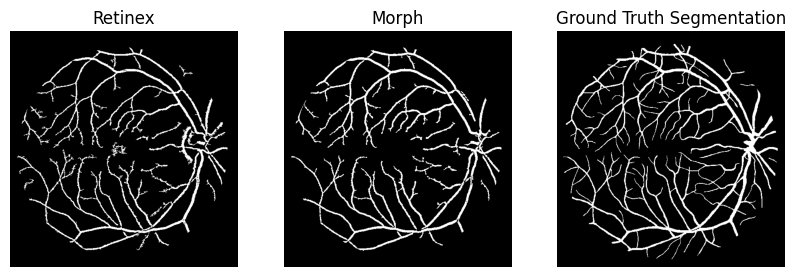

Image 16.png - IoU=0.5606721522752057
Image 16.png - IoU=0.6016191306513887


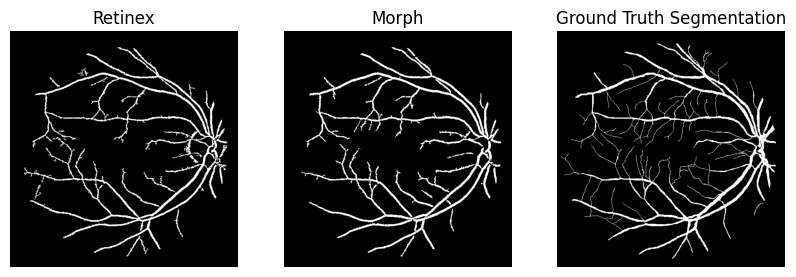

Image 12.png - IoU=0.5875766629973266
Image 12.png - IoU=0.6199789238780065


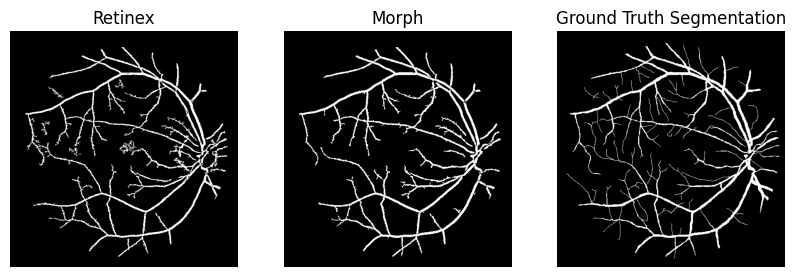

Image 13.png - IoU=0.5680546159050373
Image 13.png - IoU=0.6067083500169402


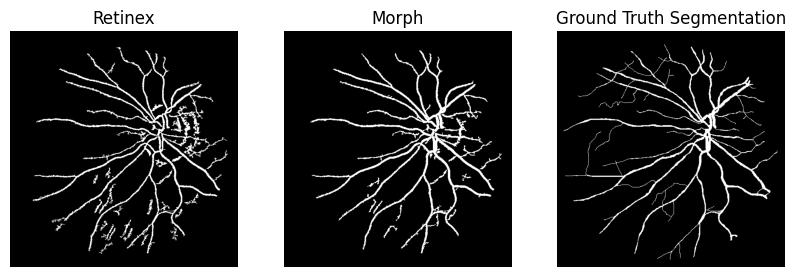

Image 11.png - IoU=0.49965498205906705
Image 11.png - IoU=0.5750153534915646


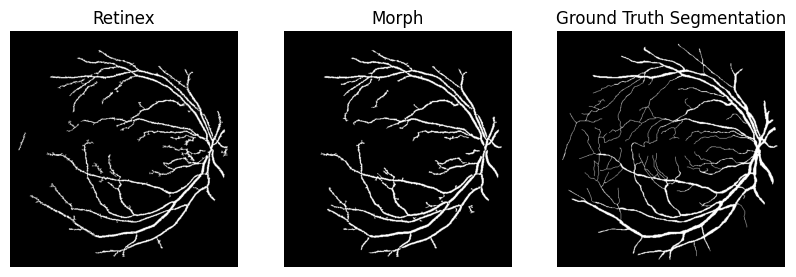

Image 10.png - IoU=0.5269174401563264
Image 10.png - IoU=0.5559992271527018


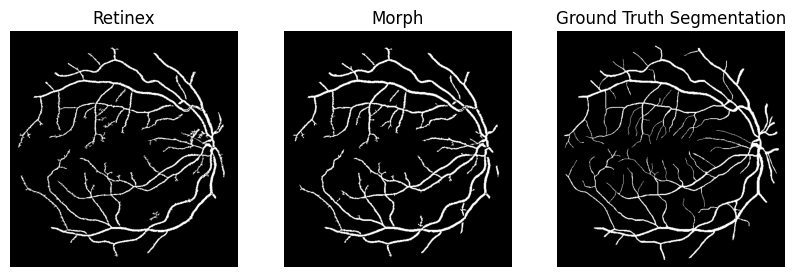

Image 20.png - IoU=0.5925427069645204
Image 20.png - IoU=0.5975242870573488


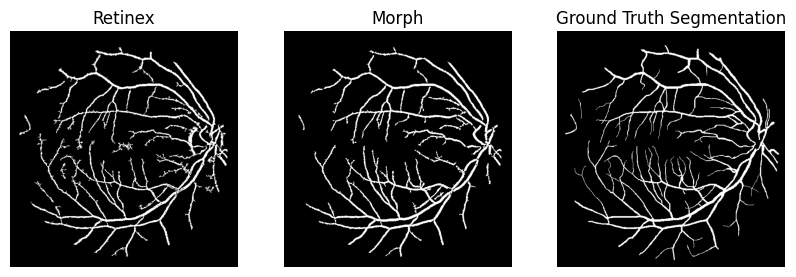

Image 18.png - IoU=0.586720027055972
Image 18.png - IoU=0.6197535120227528


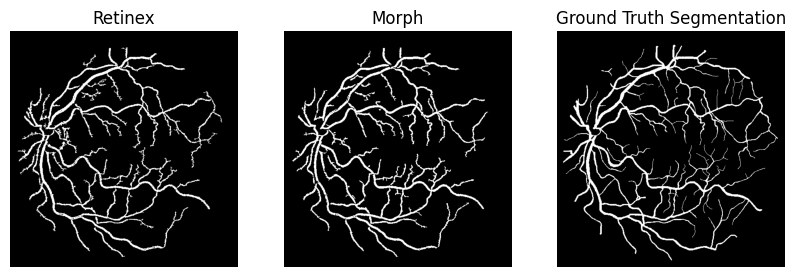

Image 19.png - IoU=0.5897176252748525
Image 19.png - IoU=0.5908071748878924


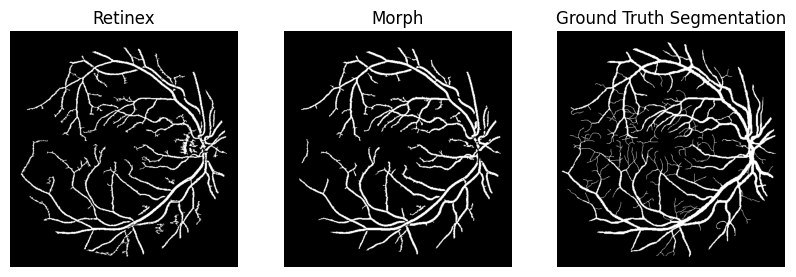

Image 4.png - IoU=0.5816561107201501
Image 4.png - IoU=0.6230563510283293


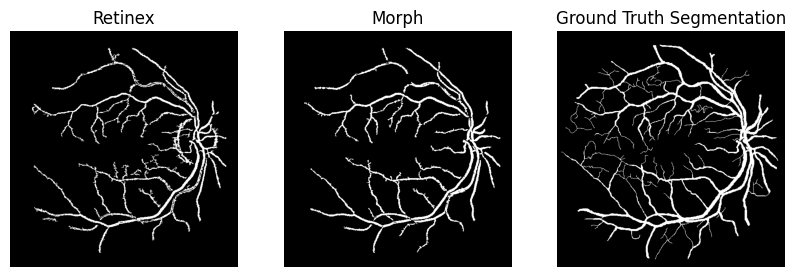

Image 5.png - IoU=0.4822683077614792
Image 5.png - IoU=0.5582319993034797


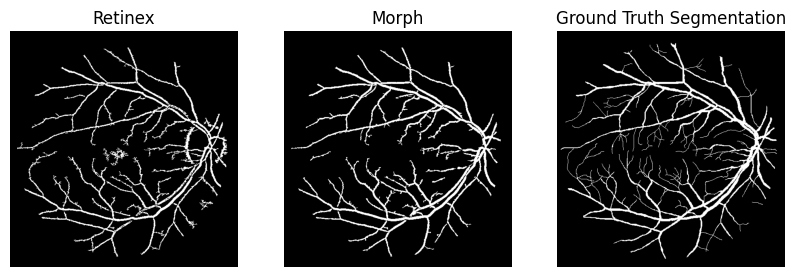

Image 7.png - IoU=0.547255880256593
Image 7.png - IoU=0.6257463645973202


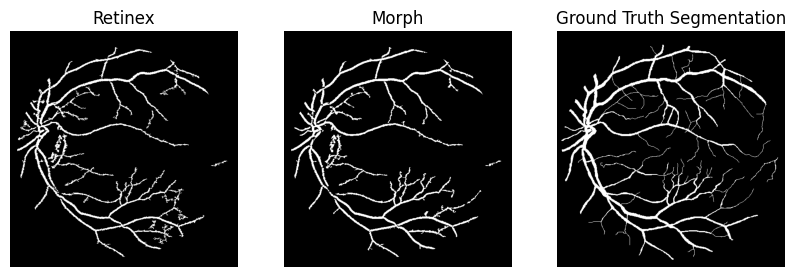

Image 6.png - IoU=0.5341937490281449
Image 6.png - IoU=0.571705608207438


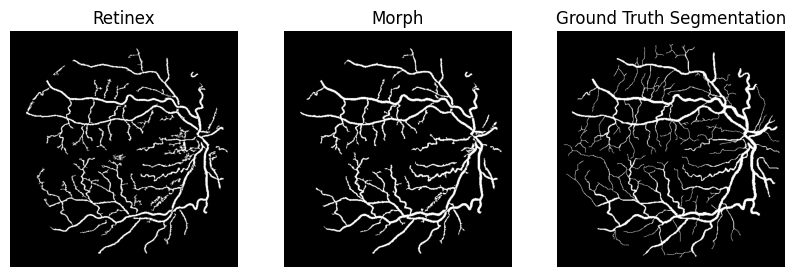

Image 2.png - IoU=0.5408469018543646
Image 2.png - IoU=0.6068761448499366


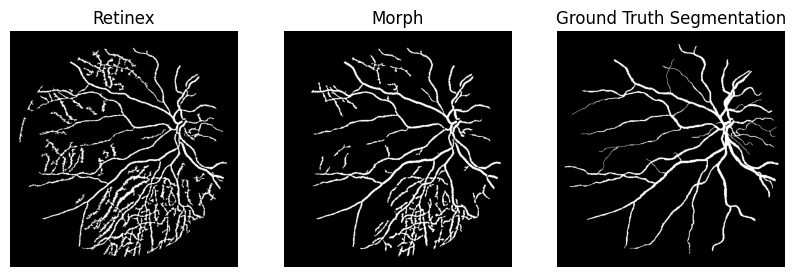

Image 3.png - IoU=0.3685662449983846
Image 3.png - IoU=0.475698771586256


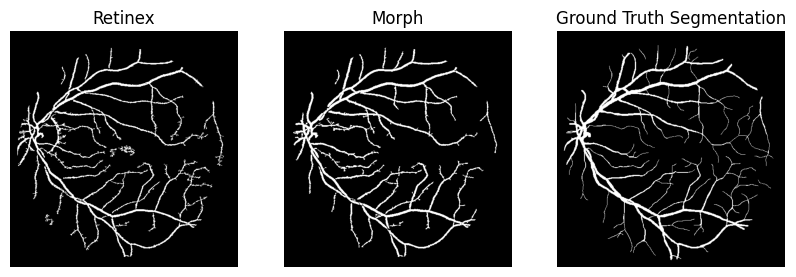

Image 1.png - IoU=0.5838840957187043
Image 1.png - IoU=0.6225942229219549
------------------------------------
Mean IoU (Wavelet)=0.5427335131260996
Mean IoU (Morph)=0.5866111171227015


In [28]:

meanIoU_1=0
meanIoU_2=0

path_input = os.path.join(db_path, 'input')

# List images in input folder
imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
print(imgs)

# For each image
for img in imgs:
    score_1, score_2 = single_IoU(img)
    meanIoU_1 += score_1
    meanIoU_2 += score_2

# Average
meanIoU_1 /= len(imgs)
meanIoU_2 /= len(imgs)
print("------------------------------------")
print("Mean IoU (Wavelet)={}".format(meanIoU_1))
print("Mean IoU (Morph)={}".format(meanIoU_2))